## Assignment 2
**Submission deadlines:**
**Submission deadlines:**
- get at least **4** points by lab session (week 24-28.03.2025)
- remaining points: by lab session (week 31.03-04.04.2025)

**Points:** Aim to get 16 out of 18+ possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

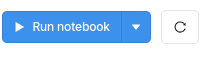

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

## Extra points

You can earn extra 2 points if all your experiments are logged with [Weights and Biases](http://wandb.ai)


# Problems


## Problem 1 [2p]:

Let's see why GPUs are useful in deep learning. Compare matrix multiplication speed for a few matrix shapes when implemented:
1. as loops in Python
2. using np.einsum
3. using numpy on CPU
4. using pytorch on CPU
5. using pytorch on GPU

Finally, consider two square matrices, $A$ and $B$. We have 4 possibilities of multiplying them or their transpositions:
1. $AB$
2. $A^TB$
3. $AB^T$
4. $A^TB^T$

Which option is the fastest? Why?

In [ ]:
import numpy as np
import torch
import time
import wandb

wandb.init(project="matrix-multiplication-benchmark")

matrix_sizes = [(32, 32), (128, 128), (1024, 1024)]


def python_loops_mult(A, B):
    n, m = len(A), len(B[0])
    C = [[0] * m for _ in range(n)]
    for i in range(n):
        for j in range(m):
            for k in range(len(B)):
                C[i][j] += A[i][k] * B[k][j]
    return C


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for size in matrix_sizes:
    A_np = np.random.rand(*size)
    B_np = np.random.rand(*size)

    A_torch = torch.tensor(A_np, dtype=torch.float32)
    B_torch = torch.tensor(B_np, dtype=torch.float32)

    A_torch_cuda = A_torch.to(device)
    B_torch_cuda = B_torch.to(device)

    times = {}

    A_list = A_np.tolist()
    B_list = B_np.tolist()
    start = time.time()
    python_loops_mult(A_list, B_list)
    times["Python Loops"] = time.time() - start

    start = time.time()
    np.einsum('ij,jk->ik', A_np, B_np)
    times["NumPy einsum"] = time.time() - start

    start = time.time()
    A_np @ B_np
    times["NumPy @"] = time.time() - start

    start = time.time()
    torch.matmul(A_torch, B_torch)
    times["PyTorch CPU"] = time.time() - start

    if torch.cuda.is_available():
        torch.cuda.synchronize()
        start = time.time()
        torch.matmul(A_torch_cuda, B_torch_cuda)
        torch.cuda.synchronize()
        times["PyTorch GPU"] = time.time() - start

    wandb.log({"matrix_size": size, **times})

wandb.finish()


NumPy @,▁▅█
NumPy einsum,▁▁█
PyTorch CPU,▂▁█
PyTorch GPU,▂▁█
Python Loops,▁▁█
NumPy @,0.04147
NumPy einsum,0.37262
PyTorch CPU,0.02645
PyTorch GPU,0.00109
Python Loops,154.99177


- Dla małych macierzy GPU nie ma przewagi, bo czas kopiowania danych do pamięci GPU oraz synchronizacja pochłaniają potencjalne zyski z równoległego przetwarzania.
-@ jest wyraźnie szybszy niż einsum, szczególnie dla większych macierzy, ponieważ korzysta z zoptymalizowanych operacji NumPy (BLAS) i dodatkowo einsum musi analizować wyrażenie Einsteina i wykonywać bardziej elastyczne operacje tensorowe

In [ ]:
import numpy as np
import time
import pandas as pd
import wandb

wandb.init(project="matrix-multiplication-benchmark")

sizes = [256, 512, 1024]
results = {}
repetitions = 100

for size in sizes:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    times = {"AB": [], "A^T B": [], "A B^T": [], "A^T B^T": []}

    for _ in range(repetitions):
        start = time.time()
        A @ B
        times["AB"].append(time.time() - start)

        start = time.time()
        A.T @ B
        times["A^T B"].append(time.time() - start)

        start = time.time()
        A @ B.T
        times["A B^T"].append(time.time() - start)

        start = time.time()
        A.T @ B.T
        times["A^T B^T"].append(time.time() - start)

    avg_times = {key: np.mean(value) for key, value in times.items()}
    results[size] = avg_times
    wandb.log({"matrix_size": size, **avg_times})

df = pd.DataFrame(results).T
df.index.name = 'Matrix Size'

print(df)
wandb.finish()


                   AB     A^T B     A B^T   A^T B^T
Matrix Size                                        
256          0.000698  0.000783  0.000726  0.000762
512          0.004709  0.004790  0.004731  0.005006
1024         0.042701  0.043350  0.044139  0.043990


A B^T,▁▂█
AB,▁▂█
A^T B,▁▂█
A^T B^T,▁▂█
matrix_size,▁▃█
A B^T,0.04414
AB,0.0427
A^T B,0.04335
A^T B^T,0.04399
matrix_size,1024


- Dla mniejszych macierzy (np. 256x256), różnice w czasie są stosunkowo niewielkie. Optymalizacja pamięci cache i zoptymalizowane algorytmy przyczyniają się do podobnych wyników.
- Dla większych macierzy (np. 1024x1024), transponowanie obydwu macierzy (A^T B^T) powoduje nieznacznie większy czas wykonania, ale ogólnie operacje są bardzo podobne.

## Problem 2: Stochastic Gradient Descent (training MNIST digits) [2p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[0.5p]** learning rate schedule
  3. **[0.5p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

## Problem 3: Tuning the Network for MNIST [2p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    a good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

## Problem 4: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

## Problem 10: Pruning [1p]

Prune the MNIST network to retain validation accuracy no worse than 0.1 percentage point at maximum sparsity (maximal number of weights removed from the network).

One way to do it is to
1. train the network,
2. set to zero the smallest weights (typically you can zero up to 50% of weights)
3. retrain the network, keeping the zeroed weights zeroed, and repeat

## Problem 11: Other tricks [1p-many]

The neural network literature is full of tricks for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand

# Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [ ]:
%matplotlib inline

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [ ]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [ ]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-3-f2b633125296>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

In [ ]:
import wandb



def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
    name=""
):
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})
    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")

    wandb.watch(model, log="all")

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #

            if epoch % 5 == 0:
                alpha *= 0.5

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            # p.grad += TODO
                            #
                            p.grad += 2 * p * decay  # L2 regularization

                        #
                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO => it is the loop above, depending on epoch
                        #

                        #
                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = 0.999* epsilon
                        #

                        #
                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        # v[...] = TODO
                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad

                        #
                        # TODO for Problem 2: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        #
                        #p -= alpha * p.grad
                        #p += - epsilon * v_prev + (1 + epsilon) * v[...]
                        #p = p  + (1 + epsilon) * v[...] - epsilon * v_prev
                        p += (1 + epsilon) * v[...] - epsilon * v_prev

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    plot_history(history)
    wandb.finish()

----------------------------------------------------------
After epoch 31 | valid err rate:  1.86% | doing  31 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 20)

-------------------------------------------
Test error rate: 1.790%, training took 30s.
-------------------------------------------


error_rate,█▅▇▆▃▅▂▂▃▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.02439
test_err_rate,0.0179
training_time,0.30691
val_error_rate,0.0186


-------------------------------------------
Test error rate: 1.790%, training took 32s.
-------------------------------------------


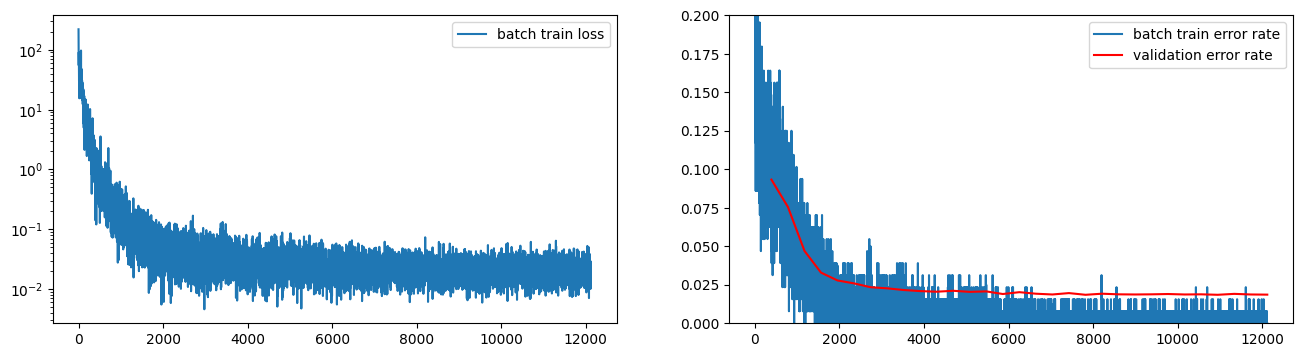

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50,
    device='cuda', decay=0.0005, name="standard")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

----------------------------------------------------------
After epoch 38 | valid err rate:  1.74% | doing  38 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 25)

-------------------------------------------
Test error rate: 1.790%, training took 35s.
-------------------------------------------


error_rate,█▆▆▃▃▃▂▂▁▁▁▂▂▃▃▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.03013
test_err_rate,0.0179
training_time,0.40998
val_error_rate,0.0174


-------------------------------------------
Test error rate: 1.790%, training took 37s.
-------------------------------------------


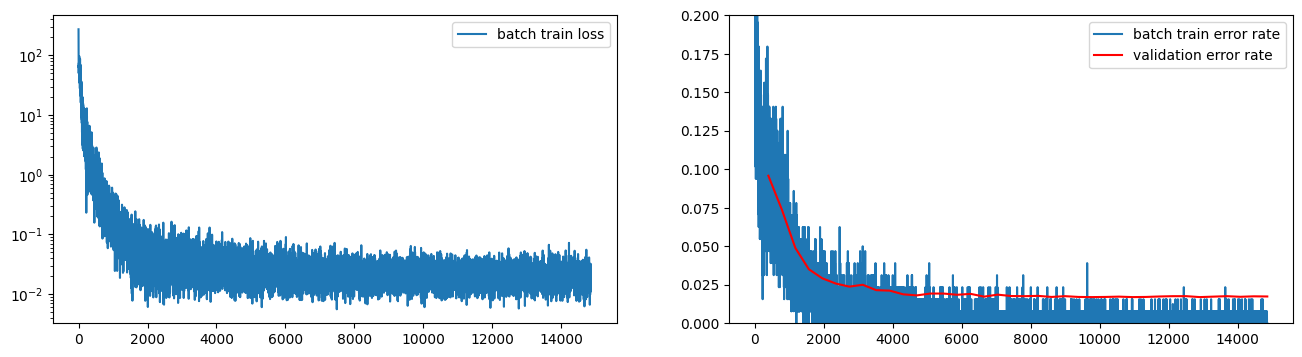

In [ ]:
import wandb
import torch
import time
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F

# Initialize Weights & Biases

def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
    name=""
):

    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})

    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}

    wandb.watch(model, log="all")
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            if epoch % 3 == 0:
                alpha *= 0.7

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            # p.grad += TODO
                            p.grad += 2 * p * decay  # L2 regularization

                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO => it is the loop above, depending on epoch

                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = 0.999* epsilon

                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad
                        p += (1 + epsilon) * v[...] - epsilon * v_prev

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]

            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)
    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    wandb.finish()


class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50,
    device='cuda', decay=0.0005, name="standard_v2")

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


#CNNs & MaxPool - zad. 4

----------------------------------------------------------
After epoch 25 | valid err rate:  1.18% | doing  25 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 16)

-------------------------------------------
Test error rate: 1.040%, training took 90s.
-------------------------------------------


error_rate,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▄▂▃▁▁▁▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,█▅▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.01983
test_err_rate,0.0104
training_time,3.68174
val_error_rate,0.0118


-------------------------------------------
Test error rate: 1.040%, training took 93s.
-------------------------------------------


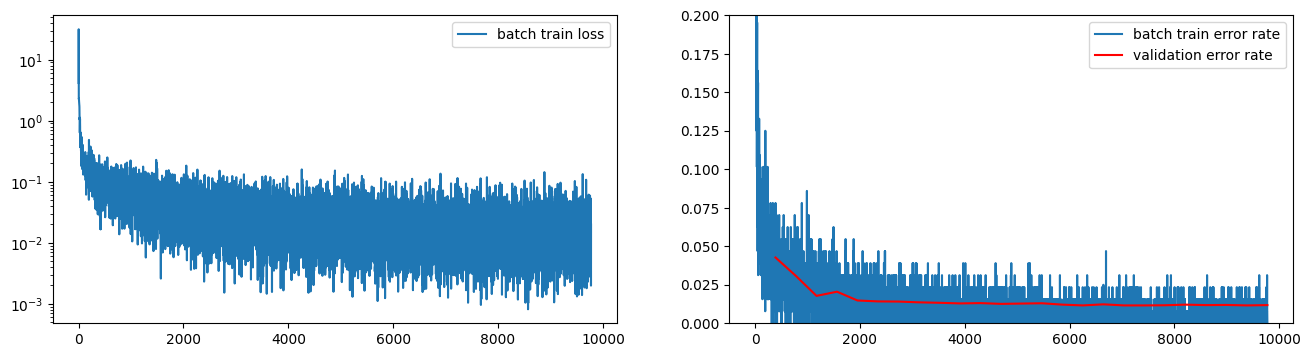

In [ ]:
import torch.nn.init as init

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 40, 5, 1, 2),
            nn.ReLU(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(40 * 7 * 7, 10)

    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        return self.out(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = CNN()


def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

with torch.no_grad():
    initialize_weights(model)


t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, num_epochs=15, max_num_epochs=30, device="cuda", name="CNN")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# ZAD. 5 - DATA AUGMENTATION


In [ ]:
import torch
import torchvision.transforms as transforms
from tqdm import tqdm

class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
        augment=False,
    ):
        """A torch dataloader that fetches data from memory."""
        self.augment = augment

        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

        # Define augmentation transforms
        self.transform = transforms.Compose([
            transforms.RandomRotation(15),       # Random rotation (-15° to +15°)
            transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
            transforms.RandomHorizontalFlip(),   # Horizontal flip (does nothing for MNIST)
            transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),  # Slight random resizing
            transforms.ToTensor()
        ])

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            batch = self.dataset[batch_indices]
            X, y = batch[0], batch[1]

            if self.augment:
                X_aug = torch.stack([self.transform(x.cpu()) for x in X])
                X = X_aug.to(X.device)

            yield X, y

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self


In [ ]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-98-e8cb39f43c71>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]
100%|██████████| 10000/10000 [00:02<00:00, 4709.26it/s]


----------------------------------------------------------
After epoch 26 | valid err rate:  1.67% | doing  26 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 17)

-------------------------------------------
Test error rate: 1.560%, training took 25s.
-------------------------------------------


error_rate,▆▃█▅▂▇▅▃█▁▃▂▃▁▁▂▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▂▅▃▃▃▃▂▁▁▂▂▂▁▁▂▂▂▁▂▂▁▂▂▁▂▁▁▁▂▂▁▁▁▂▁▁▁▂
test_err_rate,▁
training_time,▁
val_error_rate,█▆▄▃▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.01444
test_err_rate,0.0156
training_time,0.5424
val_error_rate,0.0167


-------------------------------------------
Test error rate: 1.560%, training took 27s.
-------------------------------------------


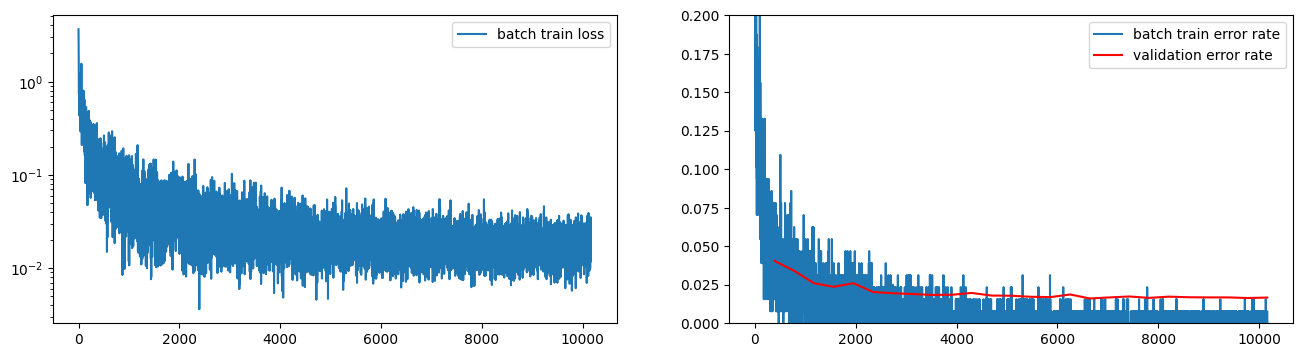

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.05)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50,
    device='cuda', decay=0.0005, name="data_augmentation")

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

#ZAD. 6 - dropout

In [ ]:
import wandb
import torch
import time
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F


def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
    run_name=""
):

    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=run_name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})

    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}

    wandb.watch(model, log="all")
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")

    try:
        tstart = time.time()
        siter = iter_
        dropout = False
        try:
            if model.dropout_ppb: dropout = True
        except:
            pass

        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            if epoch % 3 == 0:
                alpha *= 0.7

            # Dropout handling
            if dropout and model.dropout_ppb != 0:
                model.dropout_init(device)
                wandb.log({"dropout_applied": True, "dropout_probability": model.dropout_ppb})
            else:
                wandb.log({"dropout_applied": False})

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            p.grad += 2 * p * decay

                            v_prev = v[...]

                            v[...] = epsilon * v[...] - alpha * p.grad * model.dropout_masks[name]
                            p += (-epsilon * v_prev + (1+epsilon) * v[...]) * model.dropout_masks[name]
                        else:
                            v_prev = v[...]
                            v[...] = epsilon * v[...] - alpha * p.grad
                            p += (-epsilon * v_prev + (1+epsilon) * v[...])

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]

            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    plot_history(history)

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    wandb.finish()


class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)



----------------------------------------------------------
After epoch 23 | valid err rate:  1.45% | doing  23 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 15)

--------------------------------------------
Test error rate: 1.470%, training took 136s.
--------------------------------------------


dropout_probability,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▅▄▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▆█▅▃▂▂▁▃▁▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,█▇▅▃▄▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
dropout_applied,True
dropout_probability,0.4
error_rate,0
loss,0.00538
test_err_rate,0.0147


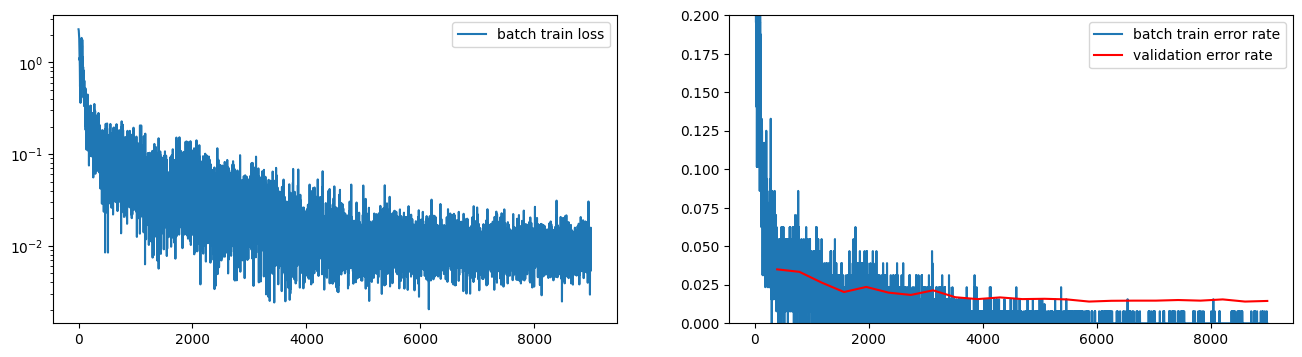

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_ppb=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout_ppb = dropout_ppb
        self.dropout_masks = {}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.apply_dropout(x, self.dropout_masks.get('fc1'), self.dropout_ppb)
        x = F.relu(self.fc2(x))
        x = self.apply_dropout(x, self.dropout_masks.get('fc2'), self.dropout_ppb)
        x = self.fc3(x)
        return x

    def loss(self, output, target):
        return F.cross_entropy(output, target)

    def apply_dropout(self, x, mask, dropout_prob):
        if mask is None or dropout_prob == 0 or not self.training:
            return x
        return x * mask

    def dropout_init(self, device):
        if self.dropout_ppb != 0:
            for name, param in self.named_parameters():
                if "weight" in name:
                    self.dropout_masks[name] = (torch.rand_like(param) > self.dropout_ppb).float().to(device)


model = SimpleNN(28*28, 4999, 3000, 10, dropout_ppb=0.4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.01)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError(f'Unknown parameter name "{name}"')


t_start = time.time()
SGD(
    model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=200,
    device=device, decay=0.0005, run_name="dropout"
)

#BATCH-NORM

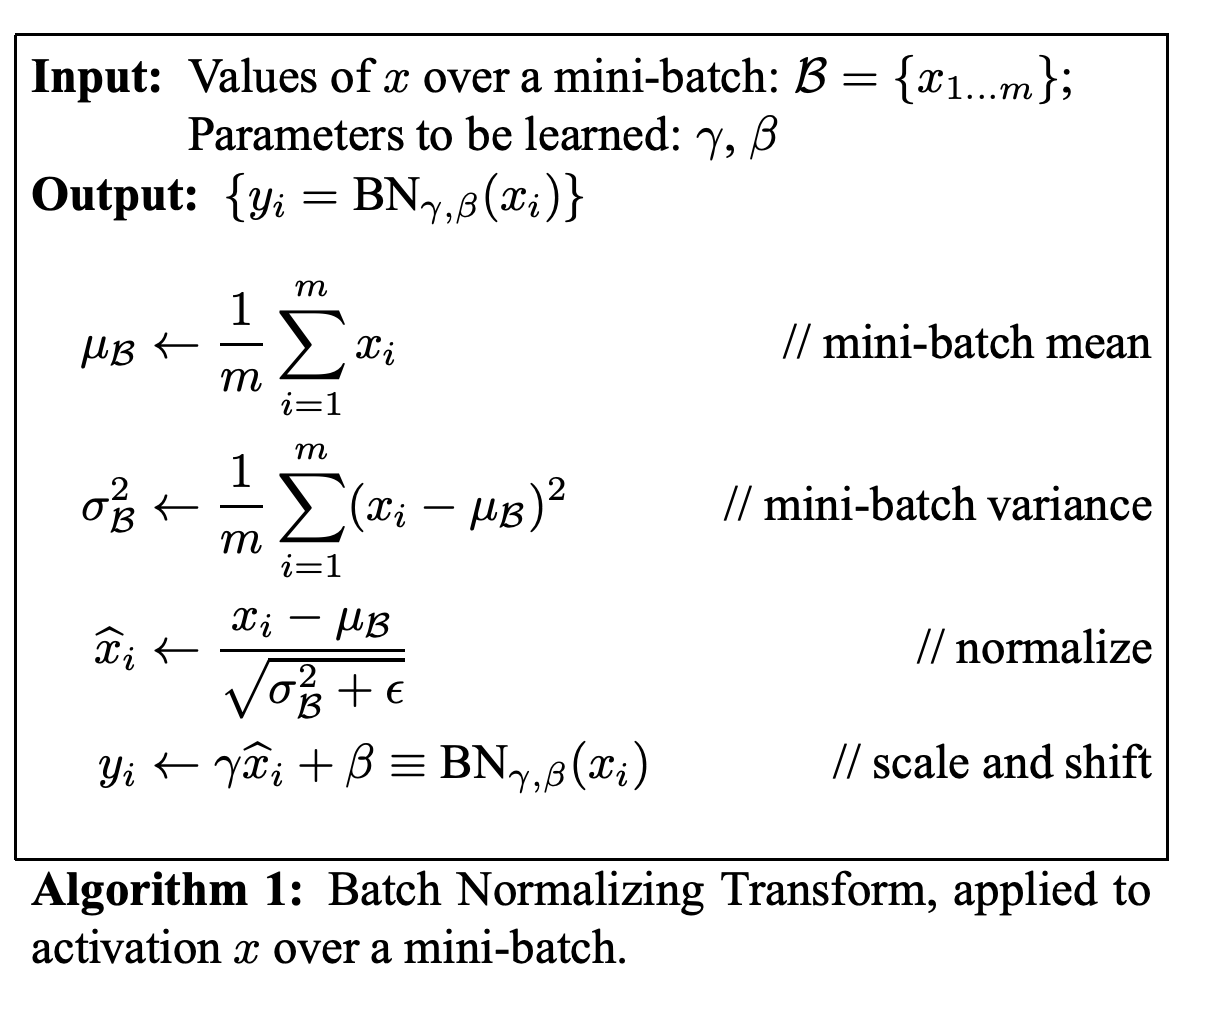

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


'''
During inference (evaluation):
The running mean and running variance calculated during training are used for normalization,
not the batch statistics of the current input. This ensures that the model behaves
consistently during evaluation, where the batch size is often 1 and thus the batch statistics
wouldn't be reliable.
'''


import wandb



def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=2,
    log_every=100,
    device="cpu",
    name=""
):
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})
    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")

    wandb.watch(model, log="all")

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #

            if epoch>10 and epoch % 5 == 0:
                alpha *= 0.5

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            # p.grad += TODO
                            #
                            p.grad += 2 * p * decay  # L2 regularization

                        #
                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO => it is the loop above, depending on epoch
                        #

                        #
                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = 0.999* epsilon
                        #

                        #
                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        # v[...] = TODO
                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad

                        #
                        # TODO for Problem 2: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        #
                        #p -= alpha * p.grad
                        #p += - epsilon * v_prev + (1 + epsilon) * v[...]
                        #p = p  + (1 + epsilon) * v[...] - epsilon * v_prev
                        p += (1 + epsilon) * v[...] - epsilon * v_prev

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    plot_history(history)
    wandb.finish()

class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

class BatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-10, momentum=0.5):
        super(BatchNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.eps = eps
        self.momentum = momentum
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True, unbiased=False)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var.detach()
        else:
            mean = self.running_mean
            var = self.running_var
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta


class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = BatchNorm(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = BatchNorm(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def loss(self, output, target):
        return F.cross_entropy(output, target)


model = Model(28*28, 2000, 1000, 10)

-----------------------------------------------------------
After epoch 122 | valid err rate:  1.29% | doing 165 epochs
-----------------------------------------------------------

Loading best params on validation set (epoch 82)

--------------------------------------------
Test error rate: 1.320%, training took 268s.
--------------------------------------------


error_rate,▇█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▃▇█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,▆▇█▆▅▄▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▃▁▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁
error_rate,0
loss,0.00115
test_err_rate,0.0132
training_time,1.29128
val_error_rate,0.0129


--------------------------------------------
Test error rate: 1.320%, training took 270s.
--------------------------------------------


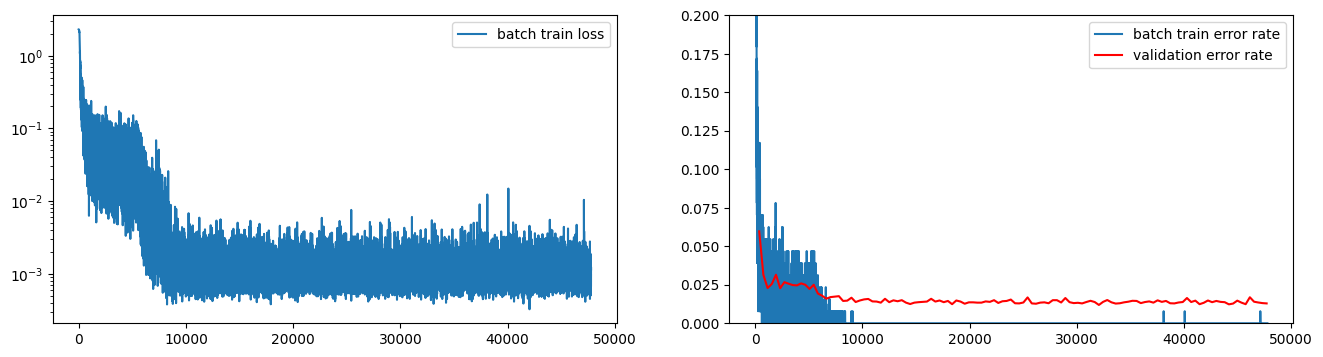

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" or "gamma" in name:
            p.normal_(0, 0.02)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError(f'Unknown parameter name "{name}"')


t_start = time.time()
SGD(
    model, mnist_loaders, alpha=0.005, epsilon=0.99, max_num_epochs=200,
    device=device, decay=0.0005, name="batch-norm"
)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))


# NORM CONSTRAINTS

In [ ]:
import wandb



def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
    name=""
):
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})
    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")

    wandb.watch(model, log="all")

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #

            if epoch % 5 == 0:
                alpha *= 0.5

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            # p.grad += TODO
                            #
                           tau = 3.0
                           if p.dim() == 2:  # Apply only to weight matrices -  L2 norm of each row is constrained to be at most tau
                                row_norms = torch.norm(p, p=2, dim=1, keepdim=True)
                                scaling_factors = torch.clamp(tau / row_norms, max=1.0)
                                p *= scaling_factors

                        #
                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO => it is the loop above, depending on epoch
                        #

                        #
                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = 0.999* epsilon
                        #

                        #
                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        # v[...] = TODO
                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad

                        #
                        # TODO for Problem 2: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        #
                        #p -= alpha * p.grad
                        #p += - epsilon * v_prev + (1 + epsilon) * v[...]
                        #p = p  + (1 + epsilon) * v[...] - epsilon * v_prev
                        p += (1 + epsilon) * v[...] - epsilon * v_prev

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    test_err_rate = compute_error_rate(model, mnist_loaders["test"])
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - t_start:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    plot_history(history)
    wandb.finish()

----------------------------------------------------------
After epoch 22 | valid err rate:  1.70% | doing  22 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 14)

-------------------------------------------
Test error rate: 1.600%, training took 27s.
-------------------------------------------


error_rate,█▇▇▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_err_rate,▁
training_time,▁
val_error_rate,█▆▄▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.0016
test_err_rate,0.016
training_time,0.39141
val_error_rate,0.017


-------------------------------------------
Test error rate: 1.600%, training took 29s.
-------------------------------------------


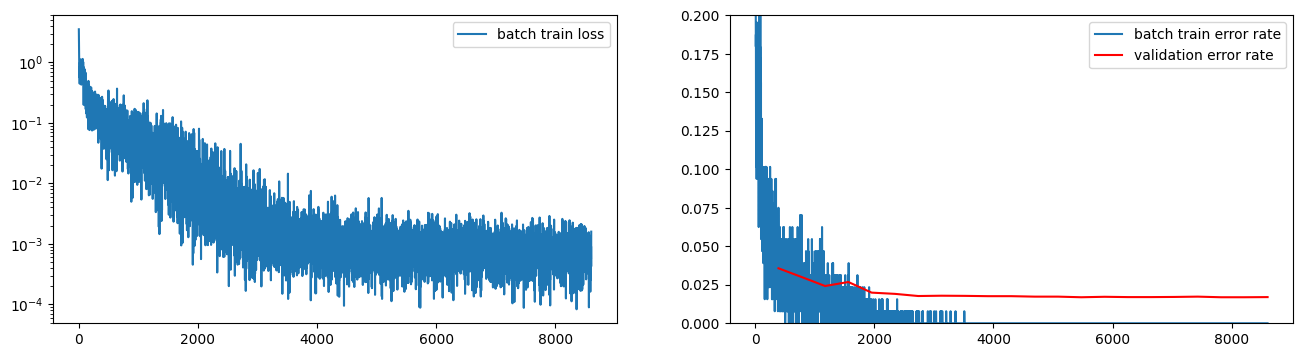

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.05)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, max_num_epochs=50,
    device='cuda', decay=0.0005, name="norm-constraint")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# PRUNING


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np
import time

def compute_error_rate(model, data_loader, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, predictions = out.max(dim=1)
            total += y.size(0)
            correct += (predictions == y).sum().item()
    return 1 - correct / total

def prune_weights(model, pruning_percentage=0.5):
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_abs = param.abs()
            num_prune = int(pruning_percentage * weight_abs.numel())
            threshold = torch.topk(weight_abs.view(-1), num_prune, largest=False).values[-1]
            mask = weight_abs >= threshold
            param.data *= mask.view_as(param)

def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
    name=""
):
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    wandb.init(project="SGD-Training", name=name, config={"alpha": alpha, "epsilon": epsilon, "decay": decay})

    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    wandb.watch(model, log="all")

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            if epoch % 5 == 0:
                alpha *= 0.5

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                wandb.log({"loss": loss.item(), "error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            p.grad += 2 * p * decay

                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad
                        p += (1 + epsilon) * v[...] - epsilon * v_prev

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))
            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    test_err_rate = compute_error_rate(model, data_loaders["test"], device)
    m = (
        f"Test error rate: {test_err_rate * 100.0:.3f}%, "
        f"training took {time.time() - tstart:.0f}s."
    )
    print("{0}\n{1}\n{0}".format("-" * len(m), m))
    wandb.log({
        "test_err_rate": test_err_rate,
        "training_time": time.time() - tstart
    })
    wandb.finish()

def train_and_prune(model, data_loaders, alpha=1e-4, epsilon=0.0, num_epochs=1, max_num_epochs=np.nan, patience_expansion=1.5, log_every=100, device="cpu", pruning_percentage=0.5, decay=0.0):
    SGD(model, data_loaders, alpha=alpha, epsilon=epsilon, num_epochs=num_epochs, max_num_epochs=max_num_epochs, patience_expansion=patience_expansion, log_every=log_every, device=device, name="Initial_Training", decay=decay)

    best_val_err = np.inf
    prune_iterations = 0
    while prune_iterations < 4:
        print(f"Pruning iteration {prune_iterations + 1}")
        prune_weights(model, pruning_percentage)

        print("Retraining after pruning...")
        SGD(model, data_loaders, alpha=alpha, epsilon=epsilon, num_epochs=num_epochs, max_num_epochs=max_num_epochs, patience_expansion=patience_expansion, log_every=log_every, device=device, name=f"Pruning_Iteration_{prune_iterations + 1}", decay=decay)

        val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
        print(f"Validation error rate after pruning iteration {prune_iterations + 1}: {val_err_rate * 100:.2f}%")

        if val_err_rate < best_val_err + 0.001:
            best_val_err = val_err_rate
            prune_iterations += 1
        else:
            print("Validation error rate increased after pruning. Stopping pruning.")
            break

class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_and_prune(model, mnist_loaders, alpha=0.01, epsilon=0.99, decay=0.0005, num_epochs=50, max_num_epochs=50, device=device, pruning_percentage=0.5)

test_err_rate = compute_error_rate(model, mnist_loaders["test"], device)
print(f"Final test error rate: {test_err_rate * 100:.3f}%")


----------------------------------------------------------
After epoch 50 | valid err rate:  1.67% | doing  50 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 18)

------------------------------------------
Test error rate: 1.620%, training took 0s.
------------------------------------------


error_rate,█▃▁▁▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▃█▂▆▄▂▂▂▁▂▁▂▂▂▁▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▂
test_err_rate,▁
training_time,▁
val_error_rate,▇▅█▂▁▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,0
loss,0.00661
test_err_rate,0.0162
training_time,0.31397
val_error_rate,0.0167


Validation error rate after pruning iteration 4: 1.62%


AttributeError: 'NoneType' object has no attribute '_log'

# HYPERPARAMETER_TUNER

In [ ]:
import random
import torch
import torch.nn as nn
import time
import numpy as np
import wandb
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def random_search_space():
    return {
        'learning_rate': 10 ** random.uniform(-5, -1),
        'filters_1': random.randint(8, 64),  # Number of filters in the first convolutional layer
        'filters_2': random.randint(16, 128),  # Number of filters in the second convolutional layer
        'kernel_size_1': random.choice([3, 5]),  # Kernel size for first convolution layer
        'kernel_size_2': random.choice([3, 5]),  # Kernel size for second convolution layer
        'activation': random.choice([nn.ReLU, nn.Sigmoid]),  # Choose activation function
        'fc_neurons': random.randint(128, 2048),  # Neurons in the fully connected layer
    }


class ConvModel(nn.Module):
    def __init__(self, filters_1, filters_2, kernel_size_1, kernel_size_2, activation, fc_neurons):
        super(ConvModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_1, kernel_size=kernel_size_1, stride=1, padding=kernel_size_1 // 2),
            activation(),
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(filters_1, filters_2, kernel_size_2, stride=1, padding=kernel_size_2 // 2),
            activation(),
        )
        self.maxpool2 = nn.MaxPool2d(2)

        self.fc = nn.Linear(filters_2 * 7 * 7, fc_neurons)
        self.out = nn.Linear(fc_neurons, 10)

    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool1(X)
        X = self.conv2(X)
        X = self.maxpool2(X)
        X = X.view(X.size(0), -1)
        X = self.fc(X)
        output = self.out(X)
        return output

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


def compute_error_rate(model, data_loader, device="cpu"):
    model.eval()
    model.to(device)
    num_errs = 0.0
    num_examples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=20,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    velocities = [torch.zeros(p.shape, device=device) for p in model.parameters()]
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            if epoch % 5 == 0:
                alpha *= 0.5

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)


                wandb.log({"train_loss": loss.item(), "train_error_rate": batch_err_rate})

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            p.grad += 2 * p * decay

                        v_prev = v[...]
                        v[...] = epsilon * v[...] - alpha * p.grad
                        p += (1 + epsilon) * v[...] - epsilon * v_prev
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))


            wandb.log({"val_error_rate": val_err_rate})

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    return history


def random_search(num_trials=10, max_epochs=50):
    best_val_accuracy = float('inf')
    best_params = None
    for trial in range(num_trials):
        params = random_search_space()


        wandb.init(project="hypertuner", entity="kicza", config=params)

        model = ConvModel(
            filters_1=params["filters_1"],
            filters_2=params["filters_2"],
            kernel_size_1=params["kernel_size_1"],
            kernel_size_2=params["kernel_size_2"],
            activation=params["activation"],
            fc_neurons=params["fc_neurons"]
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        history = SGD(model, mnist_loaders, alpha=params["learning_rate"],
                      num_epochs=max_epochs, device=device)

        test_error_rate = compute_error_rate(model, mnist_loaders["test"], device)

        print(f"Trial with Params: {params}")
        print(f"Test Error Rate: {test_error_rate * 100:.2f}%")


        wandb.log({"test_error_rate": test_error_rate})

        if test_error_rate < best_val_accuracy:
            best_val_accuracy = test_error_rate
            best_params = params


        wandb.finish()

    return best_params, best_val_accuracy


best_params, best_val_accuracy = random_search(num_trials=20)


print("Best hyperparameters found:", best_params)
print(f"Best test accuracy: {best_val_accuracy * 100:.2f}%")


test_error_rate,▁
train_error_rate,█▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▅▃▃▂▃▃▄▂▁▂▂▃▂▃▃▃▂▂▃▃▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▂▁
val_error_rate,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_error_rate,0.0243
train_error_rate,0.0125
train_loss,0.05567
val_error_rate,0.0257


Best hyperparameters found: {'learning_rate': 0.024366089795417968, 'filters_1': 49, 'filters_2': 54, 'kernel_size_1': 5, 'kernel_size_2': 5, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'fc_neurons': 1641}
Best test accuracy: 1.15%
